In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import tensorflow as tf

In [1]:
df = pd.read_csv("daily_stock_chunks\AAPL_daily.csv")
print("Data loaded successfully. Showing head:")
print(df.head())

NameError: name 'pd' is not defined

In [ ]:
df['Datetime'] = pd.to_datetime(df['Date'], utc=True)

df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

print("\nMissing values before cleaning:")
print(df.isnull().sum())

df = df.dropna(subset=['Close']).sort_values("Datetime").reset_index(drop=True)

print("\nData after dropping missing 'Close' values:")
print(df.isnull().sum())



Missing values before cleaning:
Date        1
Open        0
High        0
Low         0
Close       1
Volume      0
ticker      1
company     1
Datetime    1
dtype: int64

Data after dropping missing 'Close' values:
Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
ticker      0
company     0
Datetime    0
dtype: int64


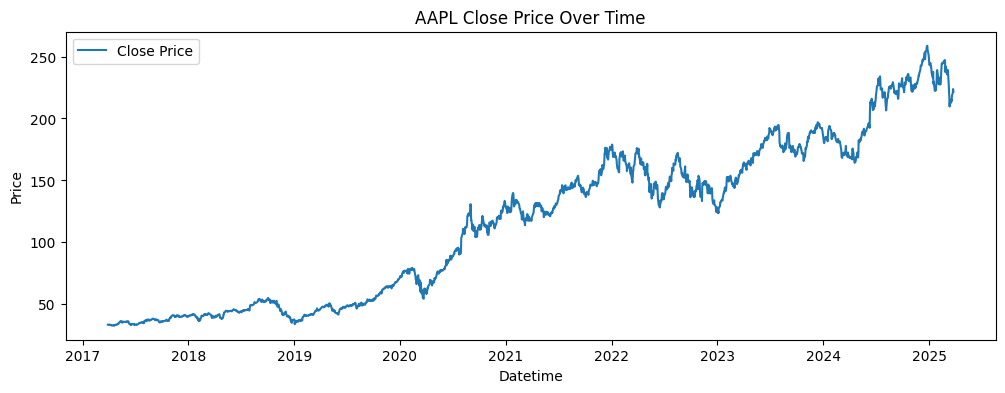

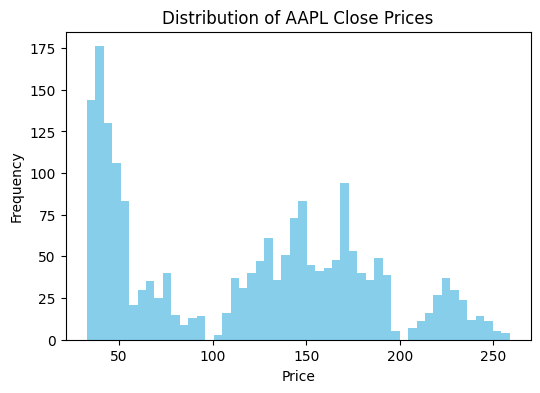

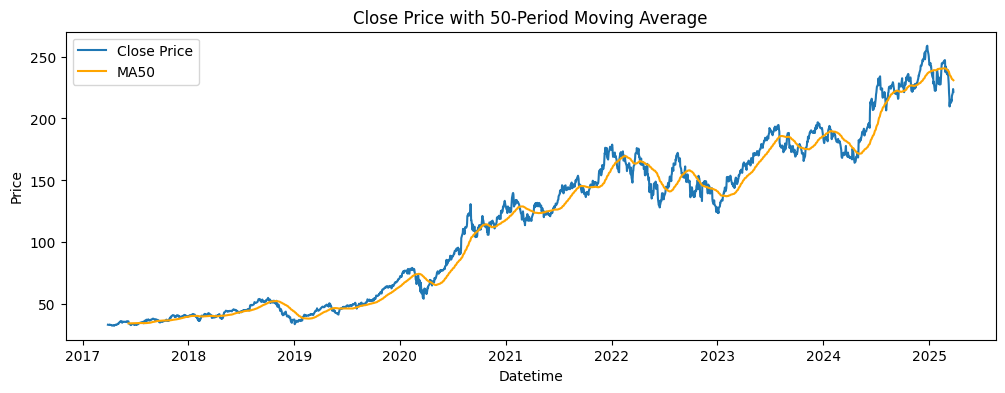

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(df['Datetime'], df['Close'], label='Close Price')
plt.title("AAPL Close Price Over Time")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(df['Close'], bins=50, color='skyblue')
plt.title("Distribution of AAPL Close Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

df['MA50'] = df['Close'].rolling(window=50).mean()
plt.figure(figsize=(12, 4))
plt.plot(df['Datetime'], df['Close'], label='Close Price')
plt.plot(df['Datetime'], df['MA50'], label='MA50', color='orange')
plt.title("Close Price with 50-Period Moving Average")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.legend()
plt.show()


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df = df.drop(columns=["MA50"], errors="ignore")

scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df[['Close']])

def create_sequences(data, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_close, seq_length=50)


In [ ]:
split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Dataset prepared for LSTM")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


Dataset prepared for LSTM
X_train shape: (1764, 50, 1)
X_test shape: (196, 50, 1)


In [ ]:
model = Sequential()
model.add(LSTM(96, return_sequences=True, input_shape=(50, 1)))
model.add(Dropout(0.2))
model.add(LSTM(96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(96))
model.add(Dropout(0.2))
model.add(Dense(1)) 

c:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 280ms/step - loss: 0.0436 - val_loss: 0.0086
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - loss: 0.0021 - val_loss: 0.0095
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - loss: 0.0018 - val_loss: 0.0044
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - loss: 0.0017 - val_loss: 0.0054
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - loss: 0.0014 - val_loss: 0.0081
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - loss: 0.0024 - val_loss: 0.0083
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - loss: 0.0016 - val_loss: 0.0052


Model saved as 'trained_lstm_daily_model.h5'


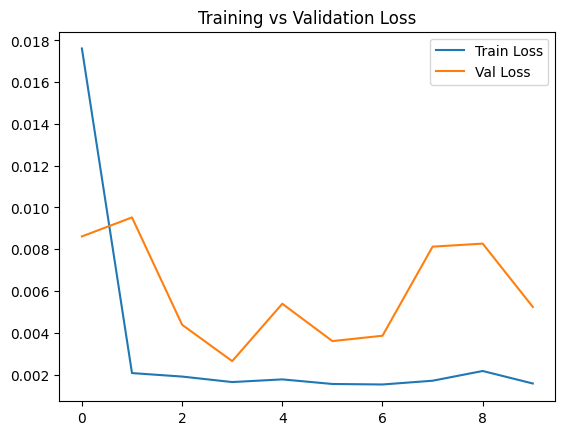

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

model.save("trained_lstm_daily_model.h5")
print("Model saved as 'trained_lstm_daily_model.h5'")

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

Loaded model from 'trained_lstm_model.h5'
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step


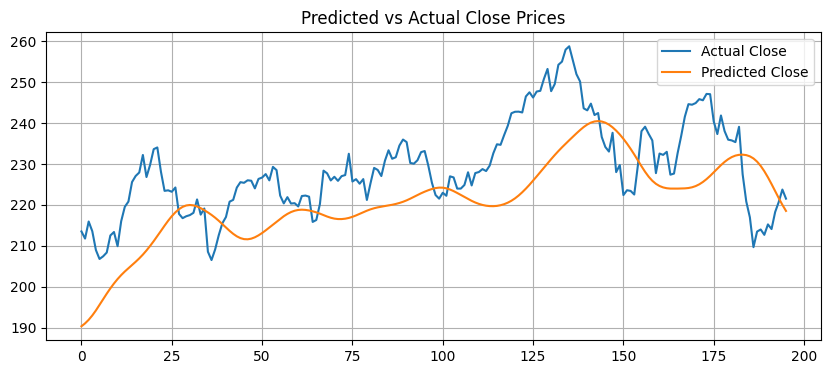

In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

model = load_model("trained_lstm_daily_model.h5")
print("Loaded model from 'trained_lstm_daily_model.h5'")

preds = model.predict(X_test)
preds_rescaled = scaler.inverse_transform(preds)
y_test_rescaled = scaler.inverse_transform(y_test)

plt.figure(figsize=(10, 4))
plt.plot(y_test_rescaled, label="Actual Close")
plt.plot(preds_rescaled, label="Predicted Close")
plt.title("Predicted vs Actual Close Prices")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
current_closes = scaler.inverse_transform(X_test[:, -1, :])

predicted_trend = (preds_rescaled.flatten() > current_closes.flatten()).astype(int)
actual_trend = (y_test_rescaled.flatten() > current_closes.flatten()).astype(int)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Classification Metrics (UP/DOWN):")
print("Accuracy: ", accuracy_score(actual_trend, predicted_trend))
print("Precision:", precision_score(actual_trend, predicted_trend))
print("Recall:   ", recall_score(actual_trend, predicted_trend))
print("F1 Score: ", f1_score(actual_trend, predicted_trend))


Classification Metrics (UP/DOWN):
Accuracy:  0.4642857142857143
Precision: 0.5833333333333334
Recall:    0.1891891891891892
F1 Score:  0.2857142857142857


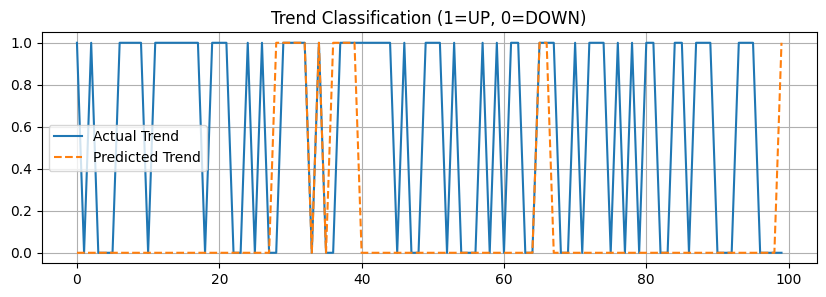

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.plot(actual_trend[:100], label="Actual Trend")
plt.plot(predicted_trend[:100], label="Predicted Trend", linestyle="dashed")
plt.title("Trend Classification (1=UP, 0=DOWN)")
plt.legend()
plt.grid(True)
plt.show()